Rnn more widely used in text analysis, because the data is sequence data.

1. 时间序列数据怎么准备
2. 网络模型怎么搭建

In [25]:
import datetime as dt

class Timer():
    def __init__(self):
        self.start_dt = None
    
    def start(self):
        self.start_dt = dt.datetime.now()
    
    def stop(self):
        end_dt = dt.datetime.now()
        print('Time taken: %s' % (end_dt - self.start_dt))

In [1]:
# config

config = {
    'data' : {
        'filename' : 'sinewave.csv',
        'columns' : [
            'sinewave'
        ],
        'sequence_length': 50,
        'train_test_split': 0.8,
        'normalise': False
    },
    'training': {
        'epochs' : 2,
        'batch_size': 32
    },
    'model': {
        'loss' : 'mse', # 回归
        'optimizer': 'adam',
        'save_dir': 'model',
        'layers': [
            {
                'type':'lstm',
                'neurons': 50,
                'input_timesteps':49,
                'input_dim':1,
                'return_seq':True
            },
            {
                'type': 'dropout',
                'rate': 0.05
            },
            {
                'type':'lstm',
                'neurons': 100,
                'return_seq': False
            },
            {
                'type': 'dropout',
                'rate': 0.05
            },
            {
                'type':'dense',
                'neurons': 1,
                'activation': 'linear'
            }
        ]
    }
}

In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('./data/sinewave.csv')

In [4]:
data

,sinewave
0,0.841471
1,0.873736
2,0.902554
3,0.927809
4,0.949402
...,...
4996,0.680667
4997,0.725324
4998,0.767118
4999,0.805885


Rnn 输入是什么格式？ 

- 序列长度一定都要是一样的

- 需要统一在一起 按照多退少补的情况

设计窗口长度都是50个。

所以 timestep = 50

In [5]:
# train, test data
splite = config['data']['train_test_split']
i_split = int(len(data)*splite)
i_split

4000

In [6]:
data_train =  data.get(config['data']['columns']).values[:i_split]
data_test = data.get(config['data']['columns']).values[i_split:]
len_train = len(data_train)
len_test = len(data_test)
print(len_train)
print(len_test)

4000
1001


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM

In [8]:
model = Sequential() # add more things later

In [9]:
# build the model

for layer in config['model']['layers']:
    neurons = layer['neurons'] if 'neurons' in layer else None
    dropout_rate = layer['rate'] if 'rate' in layer else None
    activation = layer['activation'] if 'activation' in layer else None
    return_seq = layer['return_seq'] if 'return_seq' in layer else None
    input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
    input_dim = layer['input_dim'] if 'input_dim' in layer else None
    
    if layer['type'] == 'dense':
        model.add(Dense(neurons, activation=activation))
    if layer['type'] == 'lstm':
        model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
    if layer['type'] == 'dropout':
        model.add(Dropout(dropout_rate))
    
# compile the model
model.compile(loss=config['model']['loss'], optimizer=config['model']['optimizer'])
print('Model compiled')


Model compiled


In [10]:
def normalise_windows(window_data, single_window=False):
    normalised_data = []
    window_data = [window_data] if single_window else window_data
    for window in window_data:
        normalised_window = []
        for col_i in range(window.shape[1]):
            normalised_col = [((float(p)/float(window[0, col_i])) - 1) for p in window[:, col_i]]
            normalised_window.append(normalised_col)
        normalised_window = np.array(normalised_window).T
        normalised_data.append(normalised_window)
    return np.array(normalised_data)

In [11]:
def next_window(i, seq_len, normalise):
    window = data_train[i:i+seq_len] 
    '''
    ^
    |
    cut 
    take i = 0 as an example
    data[0: 50] --> 0-49
    '''
    window = normalise_windows(window, single_window=True)[0] if normalise else window # can be seeing as we didnot do normalize window
    x = window[:-1] # forward 49
    y = window[-1, [0]] # end 1
    return x, y

In [12]:
normalise = False
data_x = []
data_y = []

'''
len_train = 4000
config['data']['sequence_length'] = 50

4000 - 50 = 3500

'''

for i in range(len_train - config['data']['sequence_length']):  
    x, y = next_window(i, config['data']['sequence_length'], normalise)
    data_x.append(x)
    data_y.append(y)

    
x = np.array(data_x)
y = np.array(data_y)

In [13]:
print(x.shape)  # 3 - dim 1.data, 2. timestep, 步长 3. vector size, 每一个步长向量的大小
print(y.shape)

(3950, 49, 1)
(3950, 1)


In [16]:
epoches = config['training']['epochs']
batch_size = config['training']['batch_size']
print(epoches)
print(batch_size)

2
32


In [31]:
def get_test_data(data, seq_len, normalise):
    data_windows = []
    for i in range(len_test - seq_len):
        data_windows.append(data_test[i:i+seq_len])
        
    data_windows = np.array(data_windows).astype(float)
    data_windows = normalise_windows(data_windows, single_window=False) if normalise else data_windows
    
    x = data_windows[:, :-1]
    y = data_windows[:, -1, [0]]
    
    return x,y

In [34]:
x_test, y_test = get_test_data(
    data,
    seq_len=config['data']['sequence_length'],
    normalise=config['data']['normalise']
)
print(x_test.shape)
print(y_test.shape)

(951, 49, 1)
(951, 1)


In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time
from numpy import newaxis
import matplotlib.pyplot as plt

In [44]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.legend()
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
    plt.show()

Model Training Started
Model 2 epochs, 32 batch size
Epoch 1/2
124/124 [==============================] - 1s 8ms/step - loss: 7.0318e-04
Epoch 2/2
124/124 [==============================] - 1s 7ms/step - loss: 6.7183e-04
Model Training Completed. Model saved as ./model/model.h5
Time taken: 0:00:01.924251
Model Predicting Sequence Multiple...
(19, 50)


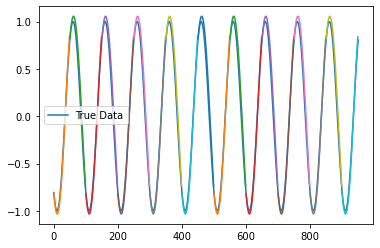

In [46]:
# Trianing the model
timer = Timer()
timer.start()
print('Model Training Started')
print('Model %s epochs, %s batch size' % (epoches, batch_size))

'''
Only save the best
'''

# callbacks = [
#     EarlyStopping(monitor = 'val_loss', patience = 2),
#     ModelCheckpoint(filepath='./model/model.h5', monitor = 'val_loss', save_best_only=True)
# ]

model.fit(
    x,
    y,
    epochs = epoches,
    batch_size = batch_size,
#     callbacks = callbacks
)

model.save('./model/model.h5')
print('Model Training Completed. Model saved as %s' % './model/model.h5')
timer.stop()

prediction_len = config['data']['sequence_length']
window_size = config['data']['sequence_length']

print('Model Predicting Sequence Multiple...')
prediction_seqs = []
for i in range(int(len(x_test)/prediction_len)):
    curr_frame = x_test[i*prediction_len]
    predicted = []
    for j in range(prediction_len):
        predicted.append(model.predict(curr_frame[newaxis, :, :])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)

predictions = prediction_seqs
print(np.array(predictions).shape)

plot_results_multiple(predictions, y_test, prediction_len)